## Calculating Global Coherence

This notebook lays out the details of how we use [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/) to calculate the significance and sensitivity of [global coherence](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.global_coherence) between insolation and oxygen isotopes from our set of records. This notebook directly follows the `Global Coherence MIS` notebook, and shows how we approach testing significance and sensitivity of these kinds of relationships. The details are documented in the original publication.

The notebook is structured as follows:

1. Define functions that will be used to calculate maximum global coherence in a given period band and calculate the significance of that coherence via AR1 surrogates
2. Define insolation curves using [climlab](https://climlab.readthedocs.io/en/latest/)
3. Calculate correlation between insolation and records to find most correlated latitude of insolation
4. Calculate global coherence between insolation at the most correlated latitude and each record
5. Plot results

In [1]:
# Importing the necessary libraries

import pickle

from tqdm import tqdm

import pyleoclim as pyleo
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation
from pylipd.lipd import LiPD

In [2]:
# Defining functions


def gcoh_band_power(gcoh, pmin, pmax, method="max"):
    """Function to calculate the amount of coherence power within a given frequency band

    Parameters
    ----------

    gcoh : pyleoclim.GlobalCoherence
        Coherence object

    pmin : float
        Minimum periodicity of the band

    pmax : float
        Maximum periodicity of the band

    method : str
        Method to calculate the power. Options are 'max' and 'sum'
    """

    periods = 1 / gcoh.coh.frequency
    coherence = gcoh.global_coh

    mask = (periods >= pmin) & (periods <= pmax)

    if method == "max":
        power = np.max(coherence[mask])
    elif method == "sum":
        power = np.sum(coherence[mask])
    else:
        raise ValueError("Method not recognized")
    return power


def calc_signif(
    series, inso_series, pmin, pmax, number=2000, sim_method="ar1sim", band_method="max"
):
    """Function to calculate the significance of coherence power in a given band using AR1 surrogates

    Parameters
    ----------

    series : pyleo.Series
        Series object used to calculate ar1 surrogates

    inso_series : pyleo.Series
        Insolation series object to calculate coherence with

    pmin : float
        Minimum periodicity of the band

    pmax : float
        Maximum periodicity of the band

    number : int
        Number of surrogates to calculate

    sim_method : str
        Method to generate the surrogates. Options are 'ar1sim' and 'phaseran'

    band_method : str
        Method to calculate the power. Options are 'max' and 'sum'
    """

    signif = []
    surrogates = pyleo.SurrogateSeries(method=sim_method, number=number)
    surrogates.from_series(series)
    for surr_series in surrogates.series_list:
        gcoh = surr_series.global_coherence(inso_series)
        power = gcoh_band_power(gcoh=gcoh, pmin=pmin, pmax=pmax, method=band_method)
        signif.append(power)
    return signif

In [3]:
with open("../../data/geo_ms_composite_dict.pkl", "rb") as handle:
    geo_ms_composite_dict = pickle.load(handle)

Loading U1446 data as it isn't stored as part of our speleothem database:

In [4]:
# Loading the marine sediment data

lipd_path = "../../data/marine_sediments/U1446.IndianOcean.2021.lpd"

L = LiPD()

if __name__ == "__main__":
    L.load(lipd_path)

ms_dict = {}

for _, row in L.get_timeseries_essentials().iterrows():
    time = row["time_values"]
    time_name = row["time_variableName"]
    time_unit = row["time_units"]
    value = row["paleoData_values"]
    value_name = row["paleoData_variableName"]
    value_unit = row["paleoData_units"]
    lat = row["geo_meanLat"]
    lon = row["geo_meanLon"]
    series = pyleo.GeoSeries(
        time=time,
        value=value,
        time_name=time_name,
        time_unit=time_unit,
        value_name=value_name,
        value_unit=value_unit,
        lat=lat,
        lon=lon,
        archiveType="Marine Sediment",
        label="U1446",
        verbose=False,
    ).interp()

    ms_dict[series.value_name] = series.slice([0, 800])

u1446 = ms_dict["d18O SW TEX86"]

Loading 1 LiPD files


  0%|                                                                                                                                    | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.01it/s]

Loaded..


Creating a [MultipleGeoSeries](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#multiplegeoseries-pyleoclim-multiplegeoseries) object for ease of analysis:

In [5]:
# Creating a multiple series with the three series

ms = (
    pyleo.MultipleGeoSeries(
        [
            geo_ms_composite_dict["Sanbao.China.2016"],
            u1446,
            geo_ms_composite_dict["BuckeyeCreek.WestVirginia.2019"],
        ]
    )
    .convert_time_unit("kyr BP")
    .interp(step=0.1)
)  # Rough interpolation to speed up calculations

<div class="alert alert-block alert-warning">
    <b>Warning:</b> Note that we have interpolated the data to a non-optimal resolution to minimize the runtime of this
    notebook. For best results that are maximally consistent with the paper, remove the rough interpolation step in the
    cell above.
</div>

Creating integrated summer insolation curves at 30N:

In [6]:
# Creating insolation objects with the most correlated latitude of insolation

with open("../../data/correlated_latitude.pkl", "rb") as handle:
    correlated_latitude = pickle.load(handle)

# array with specified kyears (can be plain numpy or xarray.DataArray)
years = np.arange(-3000, 1)

# subset of orbital parameters for specified time
orb = OrbitalTable.interp(kyear=years)

# Day numbers from June 1st to August 31st
jja_days = np.arange(152, 243)

lat = 30

days = jja_days
inso = daily_insolation(lat=lat, day=days, orb=orb).mean(dim="day")
inso_series = pyleo.Series(
    time=0 - years[::-1],
    value=inso[::-1],
    time_name="Age",
    time_unit="Kyr BP",
    value_name=f"JJA Insolation {lat} N",
    value_unit="W/m^2",
    verbose=False,
)

Defining glacial/interglacial boundaries:

In [7]:
# Create glacial/interglacial segment timings

MIS_df = pd.read_table(
    "https://lorraine-lisiecki.com/LR04_MISboundaries.txt",
    skiprows=1,
    header=0,
    delim_whitespace=True,
    nrows=90,
    index_col="Boundary",
)

interglacial_to_glacial = [f"{idx}/{idx+1}" for idx in np.arange(1, 78, 2)]
glacial_to_interglacial = [f"{idx}/{idx+1}" for idx in np.arange(2, 79, 2)]

glacial_timing = [
    (
        MIS_df.loc[interglacial_to_glacial[idx]]["Age(ka)"],
        MIS_df.loc[glacial_to_interglacial[idx]]["Age(ka)"],
    )
    for idx in range(len(glacial_to_interglacial))
]
interglacial_timing = [
    (glacial_timing[idx - 1][1], glacial_timing[idx][0])
    for idx in range(1, len(glacial_to_interglacial))
]
interglacial_timing.insert(0, (0, glacial_timing[0][0]))

Creating interglacial/glacial series objects for each our records and calculating the maximum coherence in the precessional band (here defined as 10-30 kyr):

In [8]:
# Creating interglacial/glacial series objects

glacial_coh_dict = {}
interglacial_coh_dict = {}
surrogate_coh = {series.label: [] for series in ms.series_list}

for series in tqdm(ms.series_list):
    # create glacial and interglacial series
    series = series.convert_time_unit("Kyr BP")
    value = []
    time = []
    for interval in interglacial_timing:
        series_interval = series.slice(interval)
        if len(series_interval.time) > 1:
            value.extend(series_interval.value)
            time.extend(series_interval.time)
    interglacial_series = series.copy()
    interglacial_series.time = time
    interglacial_series.value = value

    interglacial_coh_dict[series.label] = interglacial_series.global_coherence(
        inso_series
    )

    value = []
    time = []
    for interval in glacial_timing:
        series_interval = series.slice(interval)
        if len(series_interval.time) > 1:
            value.extend(series_interval.value)
            time.extend(series_interval.time)
    glacial_series = series.copy()
    glacial_series.time = time
    glacial_series.value = value

    glacial_coh_dict[series.label] = glacial_series.global_coherence(inso_series)

    num_sim = 1000

    for i in range(num_sim):
        surrogate_timing = []
        end_time = np.random.randint(0, 50)
        max_age = int(max(series.time))
        while end_time < max_age:
            start_time = end_time
            end_time += np.random.randint(30, 60)
            surrogate_timing.append([start_time, end_time])
            end_time += np.random.randint(30, 60)

        value = []
        time = []
        for interval in surrogate_timing:
            series_interval = series.slice(interval)
            if len(series_interval.time) > 1:
                value.extend(series_interval.value)
                time.extend(series_interval.time)
        surrogate_series = series.copy()
        surrogate_series.time = time
        surrogate_series.value = value

        coh = surrogate_series.global_coherence(inso_series)
        surrogate_coh[series.label].append(gcoh_band_power(coh, 10, 30))

  0%|                                                                                                                                    | 0/3 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████▎                                                                                  | 1/3 [00:23<00:47, 23.93s/it]

 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 2/3 [00:48<00:24, 24.03s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:12<00:00, 24.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:12<00:00, 24.09s/it]

In [9]:
# Loading cmap colors

with open("../../data/cmap_grouped.pkl", "rb") as handle:
    cmap = pickle.load(handle)

Calculating significance:

In [10]:
# Calculating surrogate significance (this can take a while, around 20 minutes)

surr_coh_dict = {}

for series in tqdm(ms.series_list):
    surr_coh_dict[series.label] = calc_signif(
        series.interp(), inso_series, 10, 30, number=1000
    )

  0%|                                                                                                                                    | 0/3 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████▎                                                                                  | 1/3 [01:14<02:29, 74.99s/it]

 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 2/3 [02:29<01:14, 74.73s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:45<00:00, 75.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:45<00:00, 75.04s/it]

Plotting:

0it [00:00, ?it/s]

3it [00:00, 1325.21it/s]

Text(0, 0.5, 'Maximum Coherence (10-30 kyr band)')

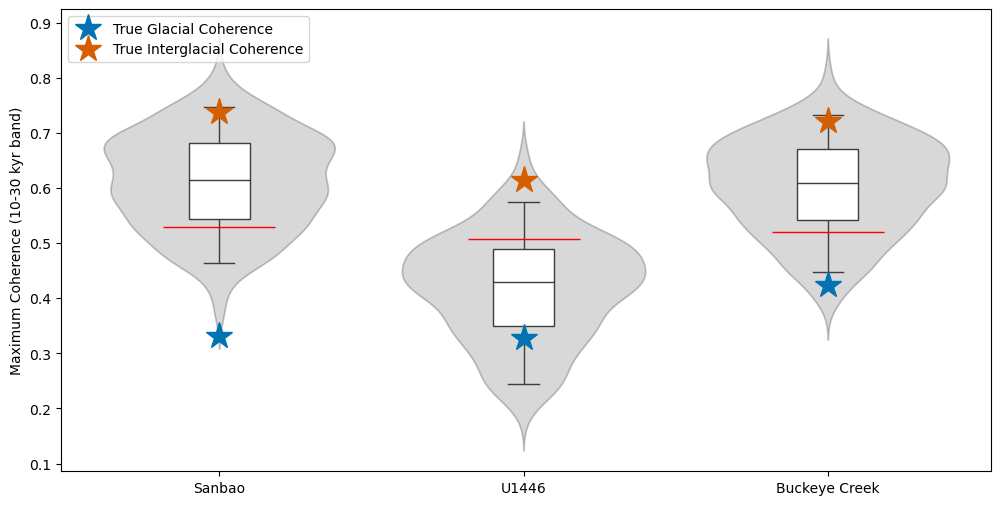

In [11]:
# Violin plots

surrogate_df = pd.DataFrame(
    columns=["Sanbao", "U1446", "Buckeye Creek"],
    data=np.array(list(surrogate_coh.values())).T,
)
# surrogate_df = surrogate_df[['Sanbao','Buckeye Creek','U1446']]
palette = sns.color_palette("colorblind")
glacial_color = palette[0]
interglacial_color = palette[3]
surrogate_color = "grey"

fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(surrogate_df, ax=ax, color=surrogate_color, alpha=0.3, inner=None)
sns.boxplot(
    surrogate_df, width=0.2, color="white", saturation=1, showfliers=False, whis=[5, 95]
)
for idx, series in tqdm(enumerate(list(ms.series_list))):
    surr_coh = surr_coh_dict[series.label]
    ax.plot(idx, np.percentile(surr_coh, 95), color="red", marker="_", markersize=80)
    ax.plot(
        idx,
        gcoh_band_power(glacial_coh_dict[series.label], 10, 30),
        "bo",
        marker="*",
        markersize=20,
        color=glacial_color,
        label="True Glacial Coherence",
    )
    ax.plot(
        idx,
        gcoh_band_power(interglacial_coh_dict[series.label], 10, 30),
        "ro",
        marker="*",
        markersize=20,
        color=interglacial_color,
        label="True Interglacial Coherence",
    )
    # ax.plot(idx,np.percentile(surrogate_df[series.label],5),color='black',marker='_',markersize=80)
    # ax.plot(idx,np.percentile(surrogate_df[series.label],95),color='black',marker='_',markersize=80)
    if idx == 0:
        ax.legend(loc="upper left")

ax.set_ylabel("Maximum Coherence (10-30 kyr band)")
# ax.axhline(.4,color='red',linestyle='--',linewidth=.5)